<a href="https://colab.research.google.com/github/AnanLu/PHYS641_2022_solution/blob/main/PS4/PS4_LIGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py

# From Prof. Siever's code
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#### Read in data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
fns = ['./drive/MyDrive/Fall_2022/PHYS641/problem_sets/PS4/LIGOdata/H-H1_LOSC_4_V2-1126259446-32.hdf5',
       './drive/MyDrive/Fall_2022/PHYS641/problem_sets/PS4/LIGOdata/L-L1_LOSC_4_V2-1126259446-32.hdf5',
       './drive/MyDrive/Fall_2022/PHYS641/problem_sets/PS4/LIGOdata/GW150914_4_template.hdf5']

In [4]:
strain_h, dt_h, utc_h = read_file(fns[0])
strain_l, dt_l, utc_l = read_file(fns[1])
template_h, template_l = read_template(fns[2])

In [5]:
def make_window(n):
    x=np.linspace(-np.pi,np.pi,n)
    return 0.5+0.5*np.cos(x)

def make_flat_window(n,m):
    tmp=make_window(m)
    win=np.ones(n)
    mm=m//2
    win[:mm]=tmp[:mm]
    win[-mm:]=tmp[-mm:]
    return win

#### Make sure dt are the same

In [6]:
if dt_h == dt_l:
    dt = dt_h

if len(strain_h) == len(strain_l):
    n = len(strain_h)
    
sampling_rate = 1.0/dt

#### Get a vanila PS

In [7]:
# Hanford DFT + Power spectrum (_ft = fourier transform, _ps = power spectrum)
strain_h_ft = np.fft.rfft(strain_h)
ps_h = np.abs(strain_h_ft**2)
# Livingston DFT + Power spectrum
strain_l_ft = np.fft.rfft(strain_l)
ps_l = np.abs(strain_l_ft**2)
# Templates DFT + Power spectrum
template_h_ft = np.fft.rfft(template_h)
ps_template_h = np.abs(template_h_ft)**2
template_l_ft = np.fft.rfft(template_l)
ps_template_l = np.abs(template_l_ft)**2

In [8]:
freqs = np.fft.rfftfreq(n, d=dt)

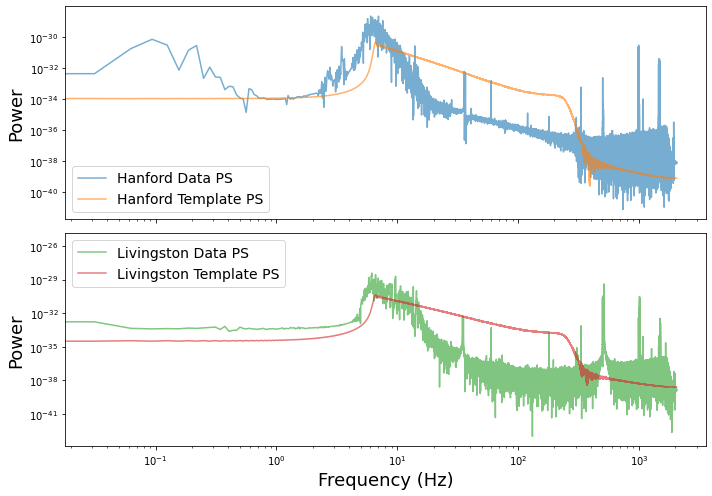

In [9]:
# My preferred plotting parameters
rcParams['figure.figsize'] = (10,7)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h, alpha=0.6, label="Hanford Data PS")
ax[0].loglog(freqs, ps_template_h, alpha=0.6, label="Hanford Template PS")
ax[1].loglog(freqs, ps_l, alpha=0.6, label="Livingston Data PS", color="C2")
ax[1].loglog(freqs, ps_template_l, alpha=0.6, label="Livingston Template PS", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Get a window function

In [10]:
# Get the window from scipy.signal.windows
window = wind.nuttall(len(strain_h))

# Make the windowed Hanford/Livingston data + the templates (_w = windowed)
strain_h_ft_w = np.fft.rfft(window*strain_h)
ps_h_w = abs(strain_h_ft_w)**2
strain_l_ft_w = np.fft.rfft(window*strain_l)
ps_l_w = abs(strain_l_ft_w)**2
template_h_ft_w = np.fft.rfft(window*template_h)
ps_template_h_w = np.abs(template_h_ft_w)**2
template_l_ft_w = np.fft.rfft(window*template_l)
ps_template_l_w = np.abs(template_l_ft_w)**2

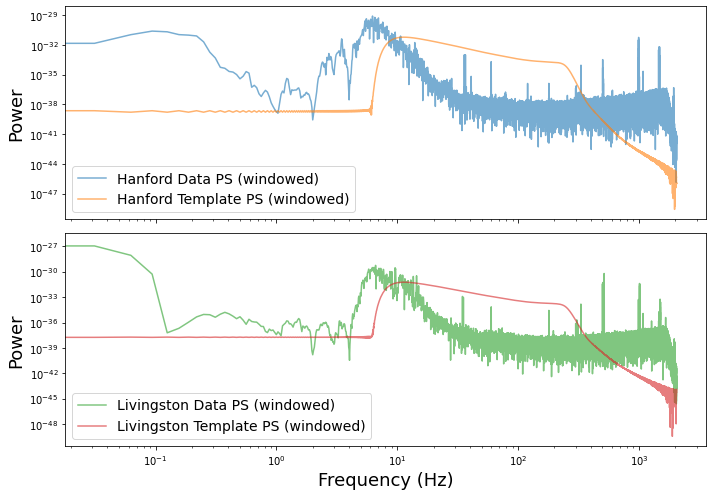

In [11]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data PS (windowed)")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template PS (windowed)")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data PS (windowed)", color="C2")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template PS (windowed)", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Chop data

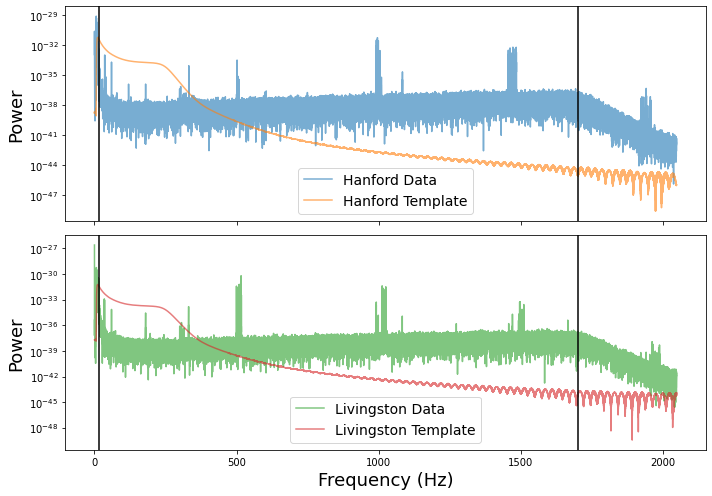

In [12]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].semilogy(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].semilogy(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].semilogy(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].semilogy(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[0].axvline(15, color='k')
ax[0].axvline(1700, color='k')
ax[1].axvline(15, color='k')
ax[1].axvline(1700, color='k')
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

#### plot in log-log space

In [13]:
ind_low = np.argmin(abs(freqs - 15))
ind_high = np.argmin(abs(freqs - 1700))

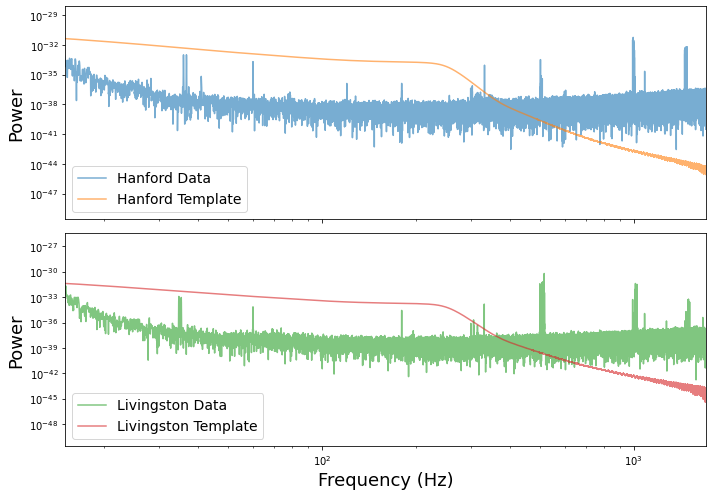

In [14]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
plt.tight_layout()
plt.show()

#### Smooth it

In [15]:
from scipy.ndimage import gaussian_filter

In [16]:
# Smooth with a Gaussian kernel of width 50 times bins
# Chose this number of time bins pretty arbitrarily.
ps_h_w_smooth = gaussian_filter(ps_h_w, sigma=50)
ps_l_w_smooth = gaussian_filter(ps_l_w, sigma=50)

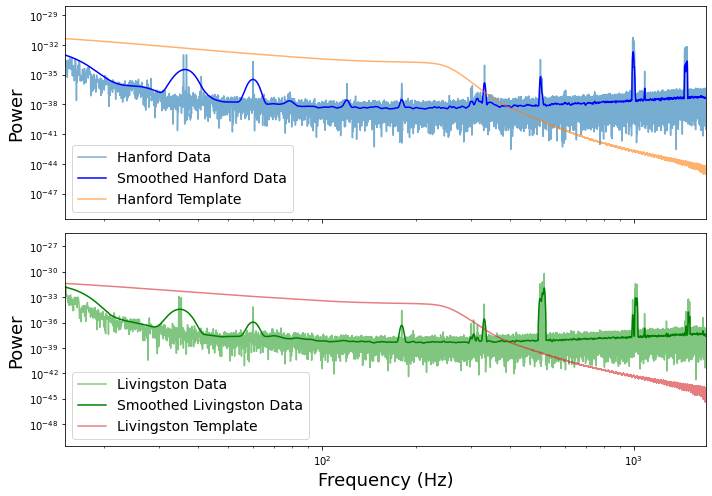

In [17]:
# Same plot as always but with smoothed data
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].loglog(freqs, ps_h_w, alpha=0.6, label="Hanford Data")
ax[0].loglog(freqs, ps_h_w_smooth, alpha=1, color='b', label="Smoothed Hanford Data")
ax[0].loglog(freqs, ps_template_h_w, alpha=0.6, label="Hanford Template")
ax[1].loglog(freqs, ps_l_w, alpha=0.6, label="Livingston Data", color="C2")
ax[1].loglog(freqs, ps_l_w_smooth, alpha=1, color='g', label="Smoothed Livingston Data")
ax[1].loglog(freqs, ps_template_l_w, alpha=0.6, label="Livingston Template", color="C3")
ax[1].set_xlabel("Frequency (Hz)", fontsize=18)
ax[0].set_ylabel("Power", fontsize=18)
ax[1].set_ylabel("Power", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[0].set_xlim(left=freqs[ind_low], right = freqs[ind_high])
plt.tight_layout()
plt.show()


#### Final noise model

In [18]:
# N is our noise model
N_h = ps_h_w_smooth
N_l = ps_l_w_smooth
# For convenience
N_h_inv_sqrt = 1/np.sqrt(N_h)
N_l_inv_sqrt = 1/np.sqrt(N_l)

In [19]:
# We want to not consider certain frequency bins that don't have well characterized
# noise, so set the noise to those to infinity (eg: inverse = 0)
for array in [N_h_inv_sqrt, N_l_inv_sqrt]:
    array[:ind_low] = 0
    array[ind_high:] = 0

#### Pre-whiten

In [20]:
strain_h_ft_whitened = N_h_inv_sqrt*strain_h_ft_w
strain_h_whitened = np.fft.irfft(strain_h_ft_whitened, n)
strain_l_ft_whitened = strain_l_ft_w*N_l_inv_sqrt
strain_l_whitened = np.fft.irfft(strain_l_ft_whitened, n)
template_h_ft_whitened = template_h_ft_w*N_h_inv_sqrt
template_h_whitened = np.fft.irfft(template_h_ft_whitened, n)
template_l_ft_whitened = template_l_ft_w*N_l_inv_sqrt
template_l_whitened = np.fft.irfft(template_l_ft_whitened, n)

#### Match filter

In [21]:
mf_ft_h = strain_h_ft_whitened * np.conj(template_h_ft_whitened)
mf_h = np.fft.irfft(mf_ft_h, n)
mf_ft_l = strain_l_ft_whitened * np.conj(template_l_ft_whitened)
mf_l = np.fft.irfft(mf_ft_l, n)

In [22]:
time = np.arange(0, n)*dt

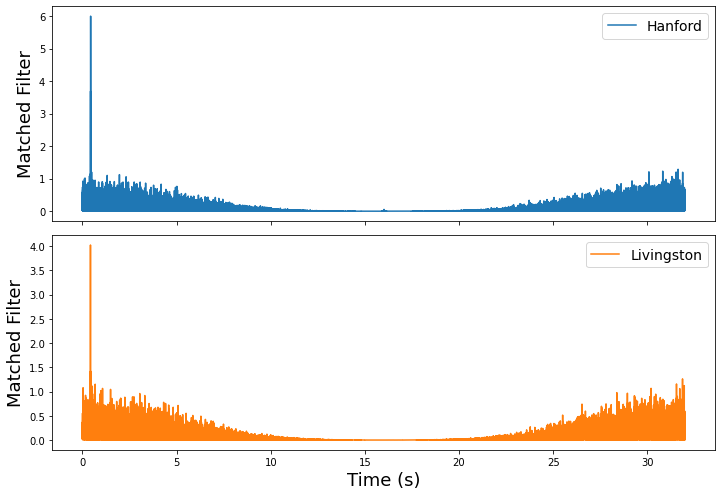

In [23]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(mf_h),label='Hanford')
ax[1].plot(time, abs(mf_l),label='Livingston', c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("Matched Filter", fontsize=18)
ax[1].set_ylabel("Matched Filter", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

#### Convert to SNR

In [24]:
sigma_h = np.sqrt(np.mean(template_h_whitened**2))
sigma_l = np.sqrt(np.mean(template_l_whitened**2))
SNR_h = mf_h/sigma_h
SNR_l = mf_l/sigma_l

In [25]:
print("Noise estimate for Hanford: %.2e" % (sigma_h))
print("Noise estimate for Livingston: %.2e" % (sigma_l))

Noise estimate for Hanford: 1.94e-01
Noise estimate for Livingston: 1.78e-01


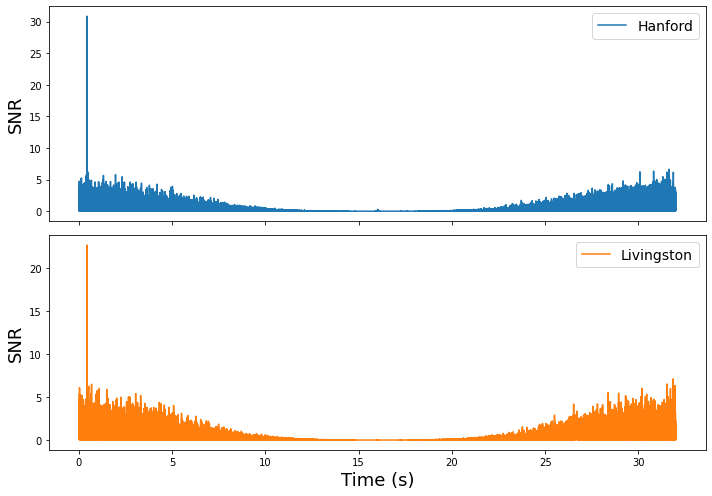

In [26]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(SNR_h),label='Hanford')
ax[1].plot(time, abs(SNR_l),label='Livingston',c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("SNR", fontsize=18)
ax[1].set_ylabel("SNR", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
print("Hanford matched filter SNR: %.2f" % (abs(SNR_h).max()))
print("Livingston matched filter SNR: %.2f" % (abs(SNR_l).max()))

Hanford matched filter SNR: 30.86
Livingston matched filter SNR: 22.64


Combined is just sqrt(H^2 + L^2)

Compare to scatter

In [28]:
rms_h = np.std(mf_h[np.argmax(mf_h)+100:np.argmax(mf_h)+1100])
rms_l = np.std(mf_l[np.argmax(mf_l)+100:np.argmax(mf_l)+1100])

SNR_h_2 = abs(mf_h)/rms_h
SNR_l_2 = abs(mf_l)/rms_l


In [29]:
print("Noise estimate for Hanford based on scatter: %.2e" % (rms_h))
print("Noise estimate for Livingston based on scatter: %.2e" % (rms_l))

Noise estimate for Hanford based on scatter: 3.53e-01
Noise estimate for Livingston based on scatter: 3.56e-01


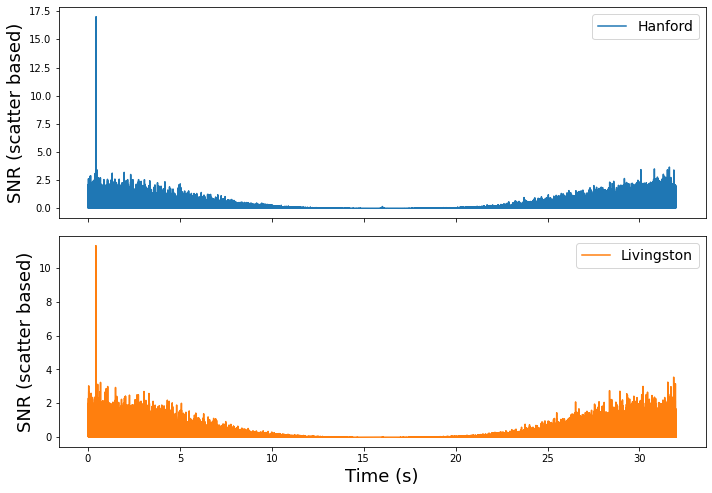

In [30]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(time, abs(SNR_h_2),label='Hanford')
ax[1].plot(time, abs(SNR_l_2),label='Livingston',c="C1")
ax[1].set_xlabel("Time (s)", fontsize=18)
ax[0].set_ylabel("SNR (scatter based)", fontsize=18)
ax[1].set_ylabel("SNR (scatter based)", fontsize=18)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
print("Hanford matched filter SNR based on scatter: %.2f" % (abs(SNR_h_2).max()))
print("Livingston matched filter SNR based on scatter: %.2f" % (abs(SNR_l_2).max()))

Hanford matched filter SNR based on scatter: 17.01
Livingston matched filter SNR based on scatter: 11.31


#### Half power frequency

In [32]:
# Power spectra of whitened templates
template_h_ps = abs(template_h_ft_whitened)**2
template_l_ps = abs(template_l_ft_whitened)**2

# Make the cumulative sum arrays
cumsum_h = np.cumsum(template_h_ps)
cumsum_l = np.cumsum(template_l_ps)

# Find the index closest to half the total sum
ind_freq_h = np.argmin(abs(cumsum_h - template_h_ps.sum()/2.))
ind_freq_l = np.argmin(abs(cumsum_l - template_l_ps.sum()/2.))


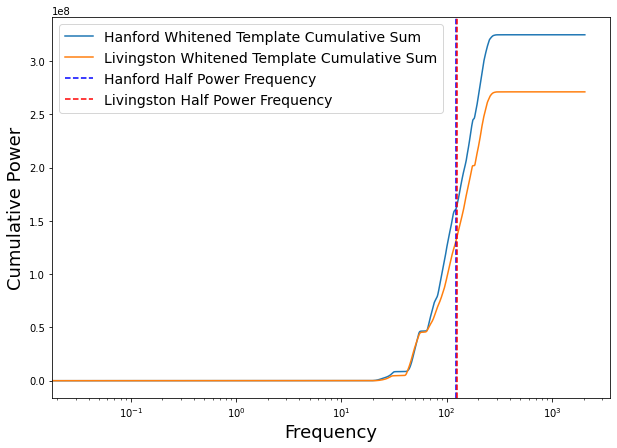

In [33]:
plt.semilogx(freqs,cumsum_h,label='Hanford Whitened Template Cumulative Sum')
plt.semilogx(freqs,cumsum_l,label='Livingston Whitened Template Cumulative Sum')
plt.axvline(freqs[ind_freq_h],ls='--',label='Hanford Half Power Frequency',c='b')
plt.axvline(freqs[ind_freq_l],ls='--',label='Livingston Half Power Frequency',c='r')
plt.legend(fontsize=14)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Cumulative Power", fontsize=18)
plt.show()


In [34]:
print('Hanford Half Power Frequency: %.2f Hz' % (freqs[ind_freq_h]))
print('Livingston Half Power Frequency: %.2f Hz' % (freqs[ind_freq_l]))

Hanford Half Power Frequency: 123.53 Hz
Livingston Half Power Frequency: 125.50 Hz


#### Localize

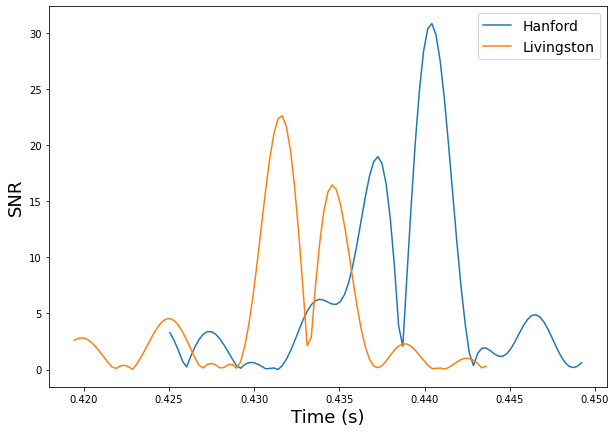

In [35]:
ind_zoom_low_h = np.argmax(SNR_h) - 50
ind_zoom_high_h = np.argmax(SNR_h) + 50
ind_zoom_low_l = np.argmax(SNR_l) - 50
ind_zoom_high_l = np.argmax(SNR_l) + 50
plt.plot(time[ind_zoom_low_h:ind_zoom_high_h], abs(SNR_h)[ind_zoom_low_h:ind_zoom_high_h],label='Hanford')
plt.plot(time[ind_zoom_low_l:ind_zoom_high_l], abs(SNR_l)[ind_zoom_low_l:ind_zoom_high_l],label='Livingston')
plt.xlabel("Time (s)", fontsize=18)
plt.ylabel("SNR",fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [36]:
delta_toa_visual = abs(time[np.argmax(abs(SNR_l))] - time[np.argmax(abs(SNR_h))])
print("Difference in arrival time of GW between Hanford and Livingston: %.2e s" % (delta_toa_visual))

Difference in arrival time of GW between Hanford and Livingston: 8.79e-03 s


In [37]:
sigma_t = 0.001
sigma_theta = 100 * sigma_t / np.sqrt(1 - (100*delta_toa_visual)**2)
sigma_theta_deg = np.rad2deg(sigma_theta)
print(f"Angular Uncertainty is {sigma_theta_deg:.2f} deg.")

Angular Uncertainty is 12.01 deg.


#### Bonus: likelihood

In [ ]:
c=3e8 #m/s
d=3e6 # m
pos_error = c * np.abs(delay_sigma)/d / np.sqrt(1 - (c*np.abs(timediff)/d)**2)

print(f"Error in position is {pos_error*180/np.pi:4.2f} degrees")

In [39]:
pip install healpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.7 MB 1.6 MB/s 


In [40]:
import healpy as hp

In [41]:
coor_liv = np.deg2rad(np.asarray([30+(33/60)+(46.42/3600), -(90+46/60+27.27/3600)]))
coor_han = np.deg2rad(np.asarray([46+27/60+18.52/3600, -(119+24/60+27.56/3600)]))

han = np.asarray([np.cos(coor_han[0])*np.cos(coor_han[1]), np.cos(coor_han[0])*np.sin(coor_han[1]), np.sin(coor_han[0])])
liv = np.asarray([np.cos(coor_liv[0])*np.cos(coor_liv[1]), np.cos(coor_liv[0])*np.sin(coor_liv[1]), np.sin(coor_liv[0])])

In [42]:
nside=256
pix_th,pix_phi = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)))

In [43]:
b = (han-liv)*6378000 #m

In [44]:
prob = np.zeros(hp.nside2npix(nside))

In [46]:
for i in range(hp.nside2npix(nside)):
    th,phi=pix_th[i],pix_phi[i]
    n = np.asarray([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    delay = b@n/3e8
    prob[i] = np.exp(-0.5*(delay-delta_toa_visual)**2/sigma_t**2)

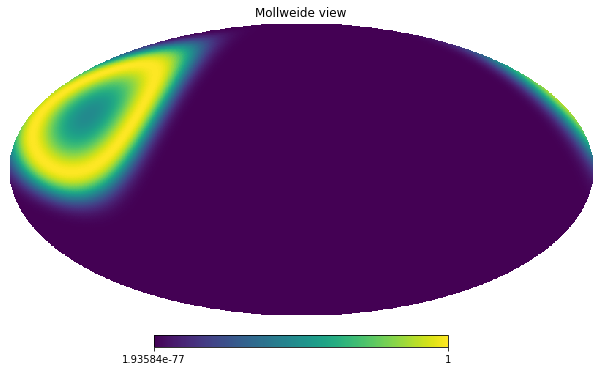

In [47]:
hp.mollview(prob)